In [229]:
import pandas as pd
import numpy as np

import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, RocCurveDisplay, auc, roc_curve

import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


import warnings
warnings.filterwarnings("ignore")

In [4]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


Проверим корректность данных рядов

In [72]:
for i, row in train_df.iterrows():
    if len(row['dates']) != len(row['values']):
        print(row['id'])
        raise ValueError(f"")

row_ids_with_nans = []
for i, row in train_df.iterrows():
    for val in row['values']:
        if math.isnan(val):
            row_ids_with_nans.append(row['id'])

f"Found some Time Series with nans. Count({len(set(row_ids_with_nans))}) ids: {row_ids_with_nans}" if len(row_ids_with_nans) > 0 else ""    

'Found some Time Series with nans. Count(88) ids: [95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 95215, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 56091, 5609

In [71]:
train_df[train_df['id'].isin(row_ids_with_nans)].head(5)

,id,dates,values,label
1979,95215,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0
2328,56091,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0
3244,63162,"[2017-12-01, 2018-01-01, 2018-02-01, 2018-03-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0
3315,29359,"[2016-11-01, 2016-12-01, 2017-01-01, 2017-02-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0
3873,12983,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0


Заодно проверим, что происходит в тестовом датасете. Просто так исключить нельзя, поскольку 

In [73]:
test_row_ids_with_nans = []
for i, row in test_df.iterrows():
    for val in row['values']:
        if math.isnan(val):
            test_row_ids_with_nans.append(row['id'])

f"Found some Time Series with nans count({len(set(test_row_ids_with_nans))}) ids: {test_row_ids_with_nans}" if len(test_row_ids_with_nans) > 0 else ""    

'Found some Time Series with nans count(21) ids: [5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 5992, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70218, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630, 70630

In [74]:
test_df[test_df['id'].isin(test_row_ids_with_nans)].head(5)

,id,dates,values
361,5992,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
922,70218,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2193,70630,"[2017-08-01, 2017-09-01, 2017-10-01, 2017-11-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4050,44222,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
6260,85761,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


Просто так исключать `nan` ряды нельзя, так как в тесте присутствуют такие же.


Проверим, что даты находятся в консистентном состоянии:

In [126]:
def check_date_consistency(dates_column: pd.Series): 
    for dates in dates_column:
        for i in range(1, len(dates)):
            delta = dates[i] - dates[i - 1]
            if delta.days > 31:
                raise ValueError("Missing date")
            if dates[i] == dates[i - 1]:
                raise ValueError("Same date at the next step")
    print("Check complete")

check_date_consistency(train_df['dates']), check_date_consistency(test_df['dates'])

Check complete
Check complete


(None, None)

In [136]:
from typing import List

def len_inconsistency(df: pd.DataFrame) -> List[int]:
    ids = []
    for _, row in df.iterrows():
        if len(row['dates']) != len(row['values']):
            ids.append(row['id'])

    return ids        

len_inconsistency(train_df), len_inconsistency(test_df)

([], [])

### Графический анализ

Распределение классов в обучающей выборке

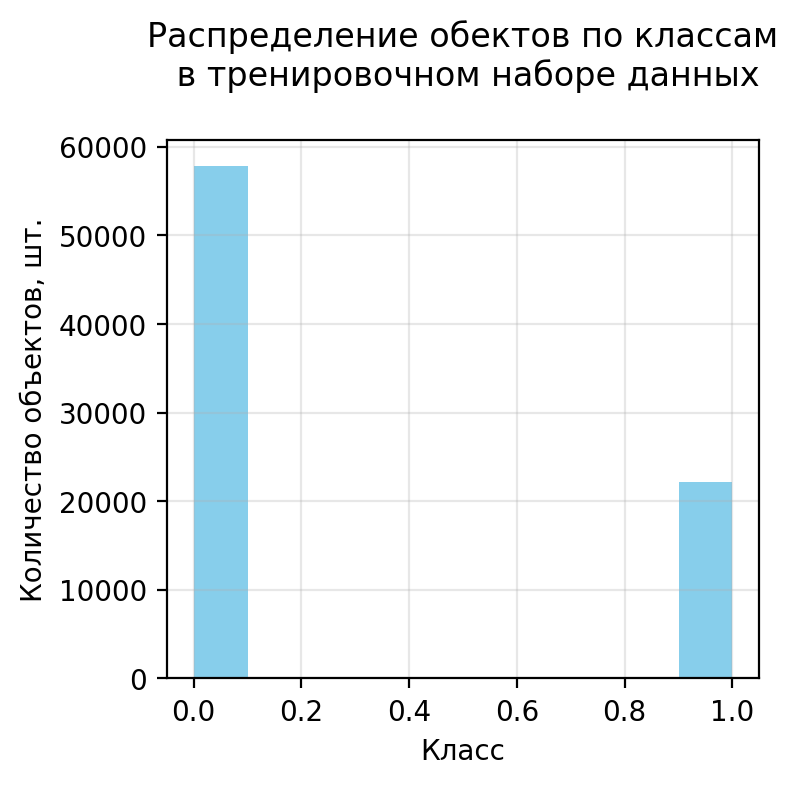

In [138]:
plt.figure(figsize=(4, 4))
plt.hist(train_df['label'], color='skyblue')

plt.title("Распределение обектов по классам\n в тренировочном наборе данных\n")
plt.xlabel("Класс")
plt.ylabel("Количество объектов, шт.")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

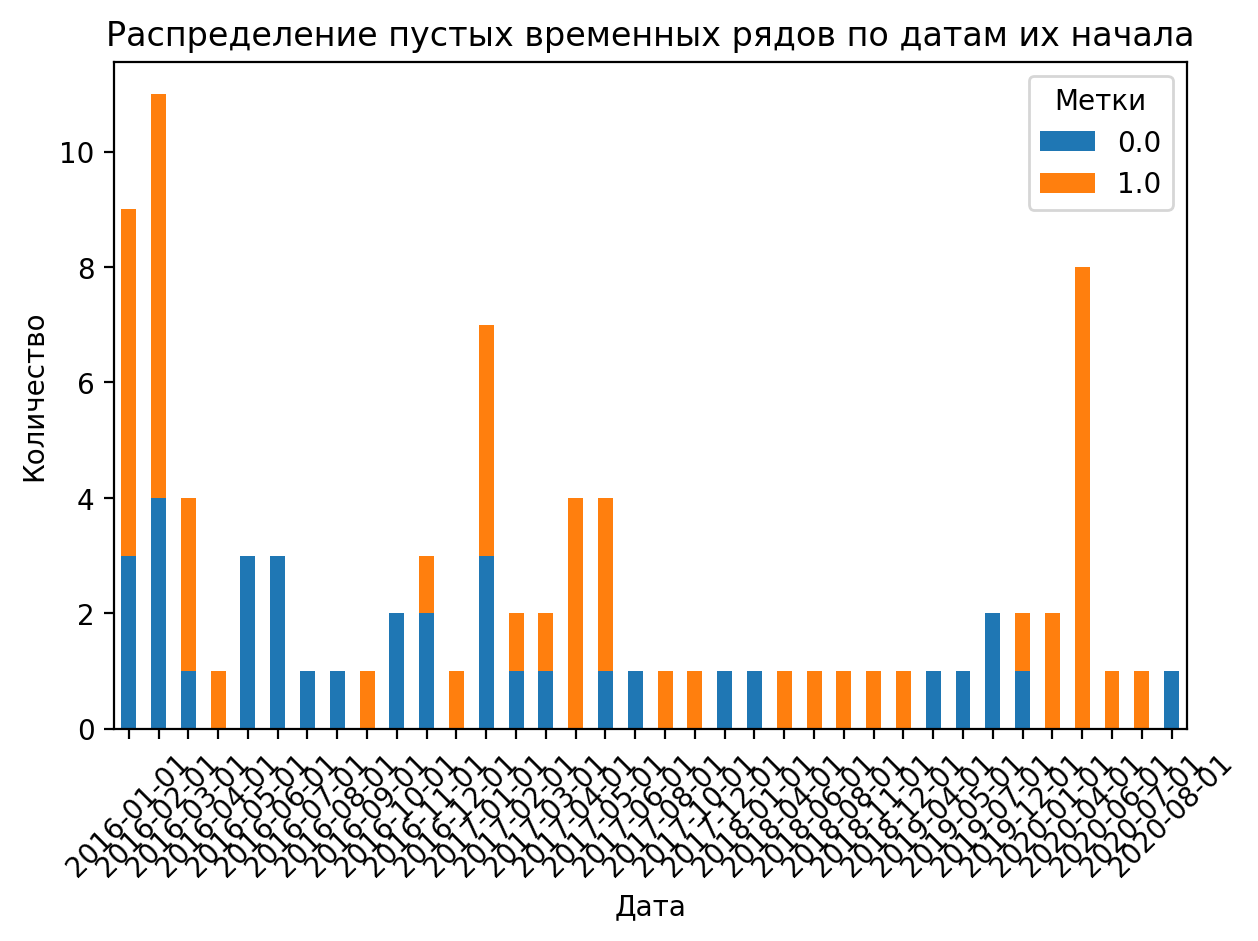

In [10]:
nan_ts = train_df[train_df['id'].isin(row_ids_with_nans)]

pd.concat([nan_ts['dates'].apply(lambda x: x[0]), nan_ts['label']], axis=1)

pivot_table = pd.concat([nan_ts['dates'].apply(lambda x: x[0]), nan_ts['label']], axis=1).pivot_table(index='dates', columns='label', aggfunc='size', fill_value=0)

# Построение стейк диаграммы
pivot_table.plot(kind='bar', stacked=True)

plt.hist(test_df[test_df['id'].isin(test_row_ids_with_nans)]['dates'])

plt.title('Распределение пустых временных рядов по датам их начала')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend(title='Метки')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [137]:
train_wn_df = train_df[~train_df['id'].isin(row_ids_with_nans)].copy()
train_wn_df.head(5)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


Посмотрим на графики временных рядов в осях среднего значения и дисперсии

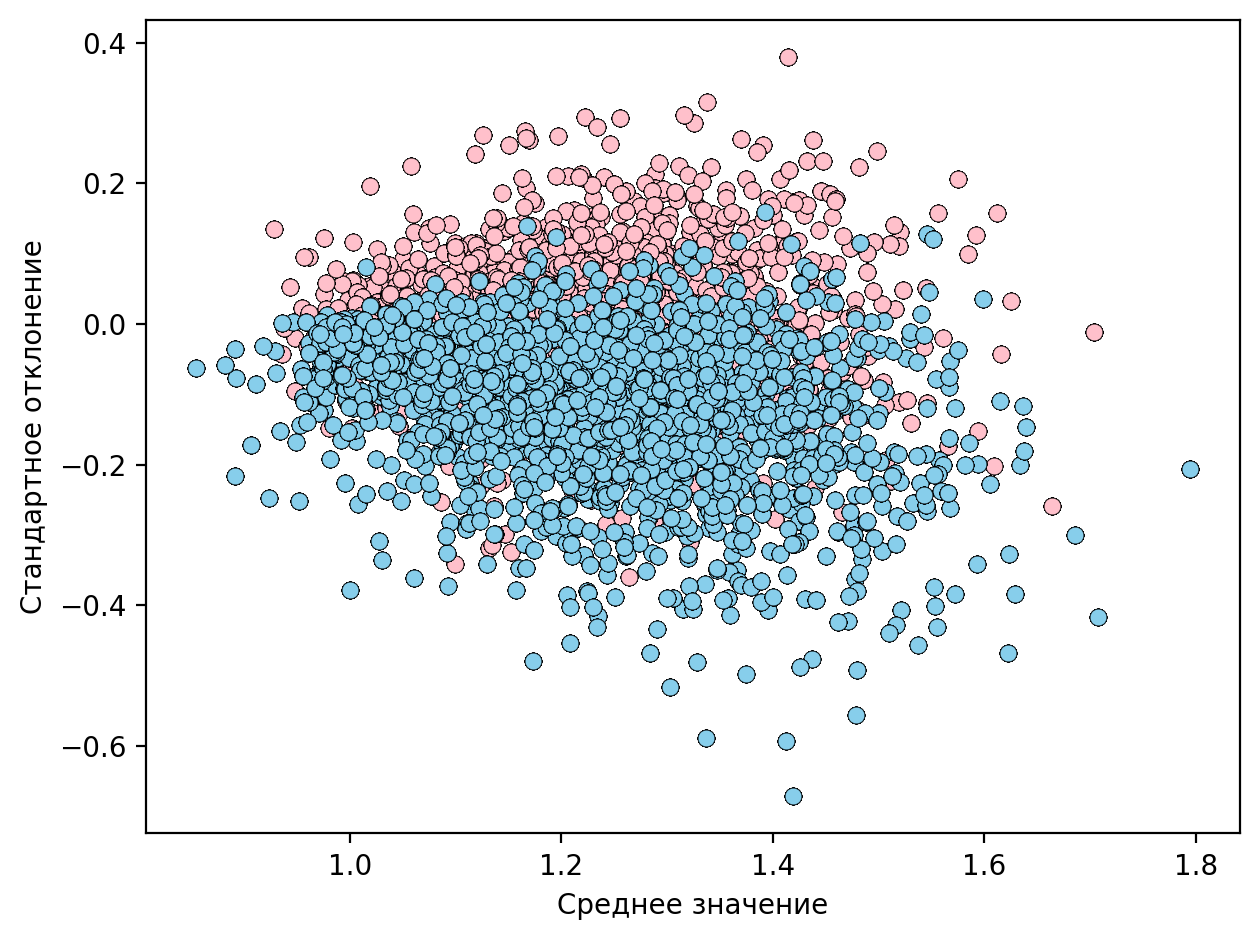

In [75]:
for i, row in train_wn_df[train_wn_df['label'] == 0].sample(2000).iterrows():
    plt.scatter([row['values'].std() for _ in range(len(row['values']))], [row['values'].mean() for _ in range(len(row['values']))], color='pink', edgecolors= "black", linewidth=0.2)

for i, row in train_wn_df[train_wn_df['label'] == 1].sample(2000).iterrows():
    plt.scatter([row['values'].std() for _ in range(len(row['values']))], [row['values'].mean() for _ in range(len(row['values']))], color='skyblue', edgecolors= "black", linewidth=0.2)    

plt.ylabel("Стандартное отклонение")
plt.xlabel("Среднее значение")
plt.tight_layout()
plt.show()

Видим, что распределения точек, хоть и накладываются друг на друга, но в принципе могут стать хорошими признаками

In [142]:
train_wn_df['razmax'] = train_wn_df['values'].apply(lambda x: x.max() - x.min())

In [13]:
first_class_values = []
for i, row in train_wn_df[train_wn_df['label'] == 1].iterrows():
    for val in row['values']:
        first_class_values.append(val)


second_class_values = []
for i, row in train_wn_df[train_wn_df['label'] == 0].iterrows():
    for val in row['values']:
        second_class_values.append(val)

In [14]:
np.array(first_class_values).std(), np.array(second_class_values).std()

(1.2388608675701491, 1.2180570382130775)

<Axes: >

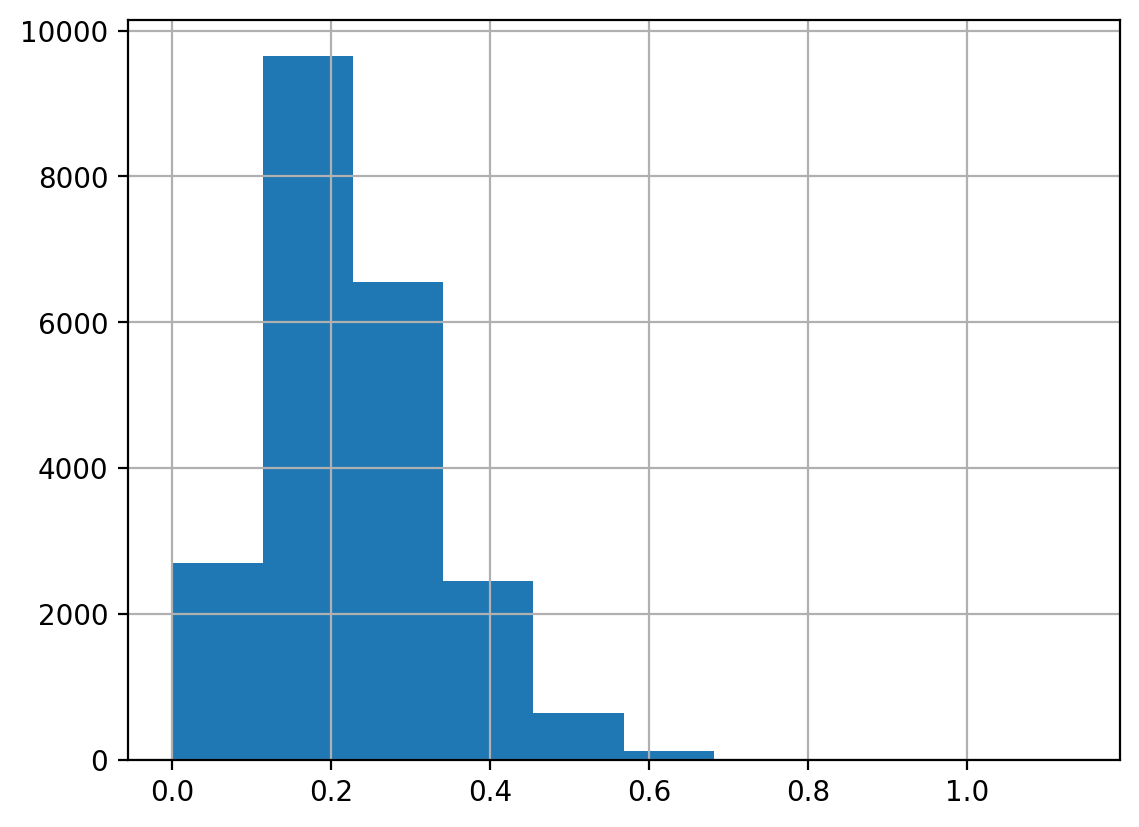

In [15]:
fc_mean = np.array(first_class_values).mean()
train_wn_df[train_wn_df['label'] == 1]['values'].apply(lambda x: np.abs(np.mean(x) - np.abs(fc_mean))).hist()

<Axes: >

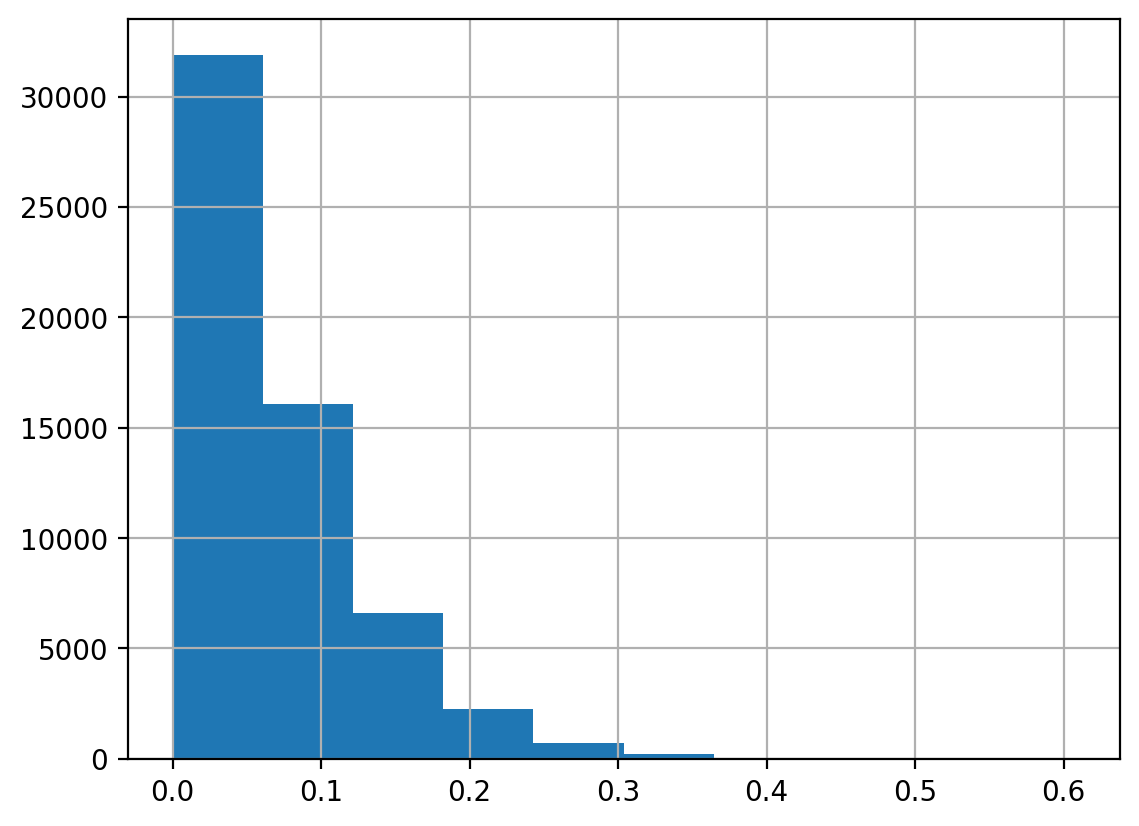

In [16]:
sc_mean = np.array(second_class_values).mean()
train_wn_df[train_wn_df['label'] == 0]['values'].apply(lambda x: np.abs(np.mean(x) - np.abs(sc_mean))).hist()

<Axes: >

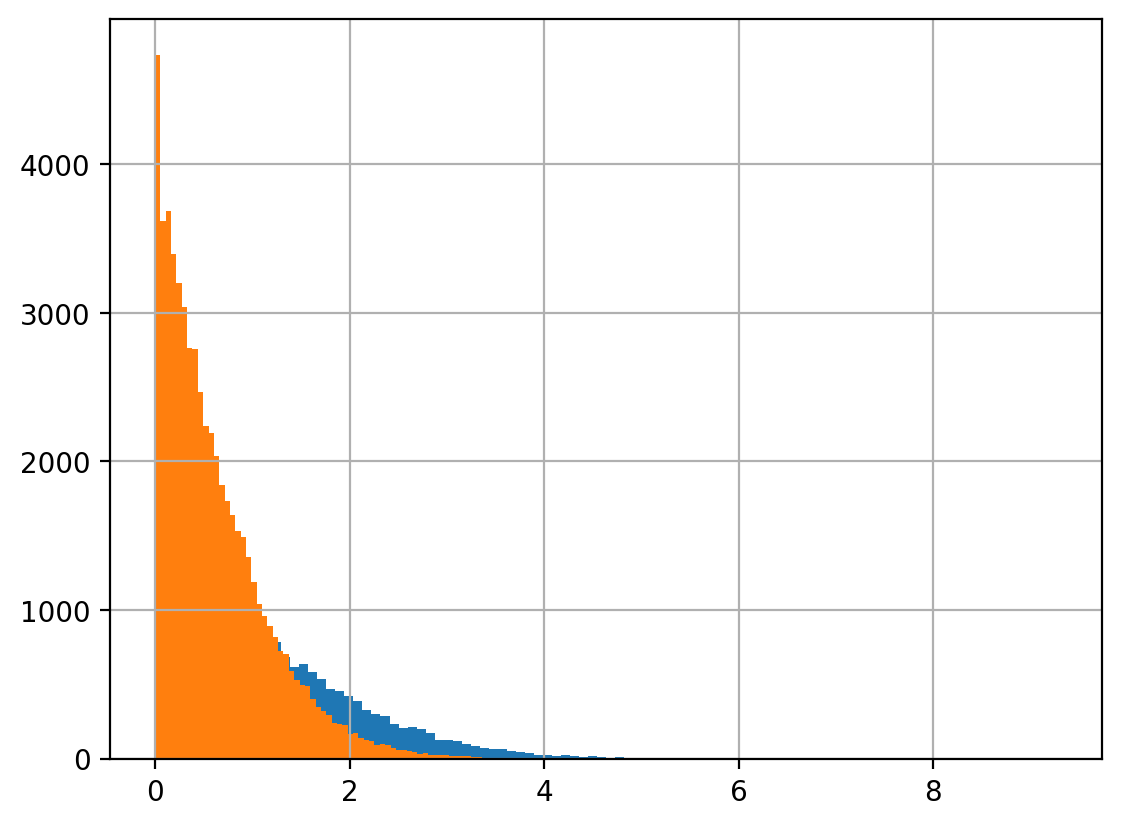

In [17]:
train_wn_df[train_wn_df['label'] == 1]['values'].apply(lambda x: np.abs(np.mean(x) / np.abs(fc_mean))).hist(bins=100)
train_wn_df[train_wn_df['label'] == 0]['values'].apply(lambda x: np.abs(np.mean(x) / np.abs(fc_mean))).hist(bins=100)

<Axes: >

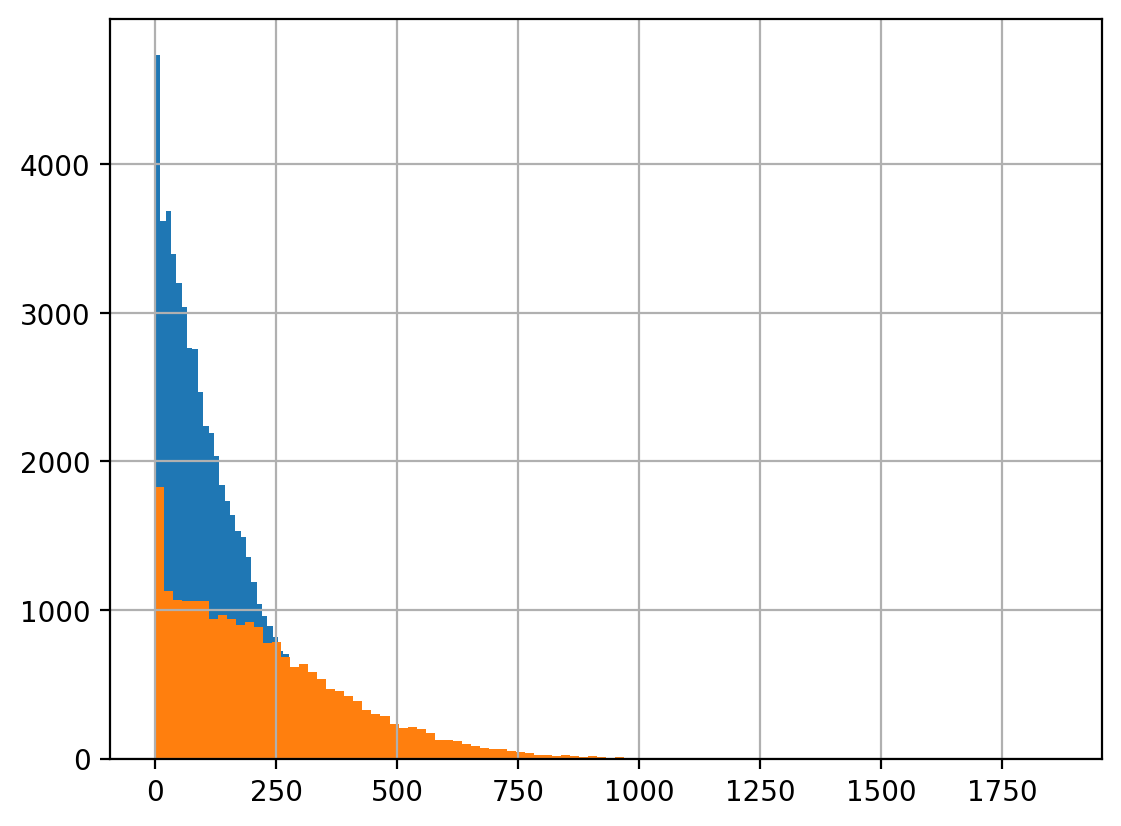

In [18]:

train_wn_df[train_wn_df['label'] == 0]['values'].apply(lambda x: np.abs(np.mean(x) / np.abs(sc_mean))).hist(bins=100)
train_wn_df[train_wn_df['label'] == 1]['values'].apply(lambda x: np.abs(np.mean(x) / np.abs(sc_mean))).hist(bins=100)

<Axes: >

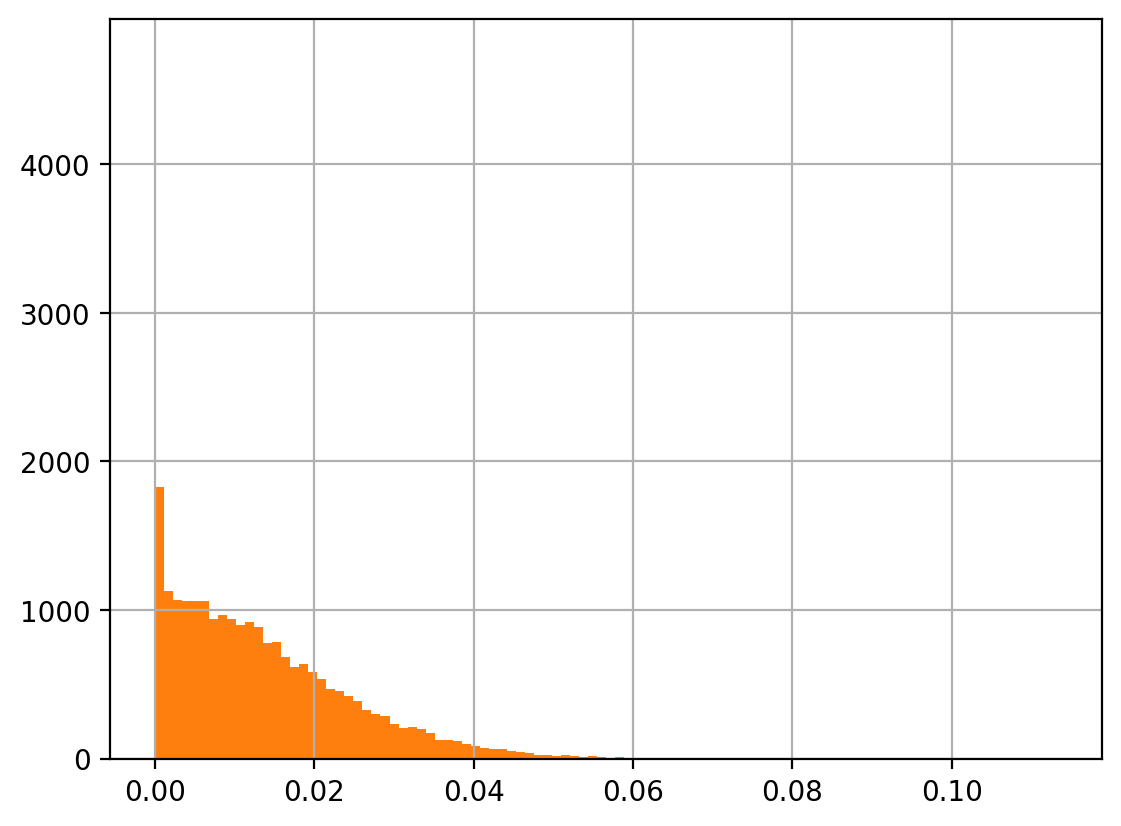

In [19]:

train_wn_df[train_wn_df['label'] == 0]['values'].apply(lambda x: np.abs(np.mean(x) * np.abs(sc_mean))).hist(bins=100)
train_wn_df[train_wn_df['label'] == 1]['values'].apply(lambda x: np.abs(np.mean(x) * np.abs(fc_mean))).hist(bins=100)

In [20]:
np.array(first_class_values).mean(), np.array(second_class_values).mean()


(-0.11051386675179183, 0.000550031428992925)

Производные

In [145]:
train_wn_df['dv_mean'] = train_wn_df['values'].apply(lambda x: ((np.array(x) - np.array(x[1:].tolist() + [0]))[:-1]).mean())

In [146]:
train_wn_df['dv_value'] = train_wn_df['values'].apply(lambda x: ((np.array(x) - np.array(x[1:].tolist() + [0]))[:-1]))

In [147]:
train_wn_df['sec_dv_mean'] = train_wn_df['dv_value'].apply(lambda x: ((np.array(x) - np.array(x[1:].tolist() + [0]))[:-1]).mean())

In [148]:
train_wn_df['mean'] = train_wn_df['values'].apply(lambda x: x.mean())

In [149]:
train_wn_df['std'] = train_wn_df['values'].apply(lambda x: x.std())

In [150]:
train_wn_df['dv_std'] = train_wn_df['values'].apply(lambda x: ((np.array(x) - np.array(x[1:].tolist() + [0]))[:-1]).std())

In [151]:
train_wn_df['mean_mul_dv_mean'] = train_wn_df['mean'] * train_wn_df['dv_mean']

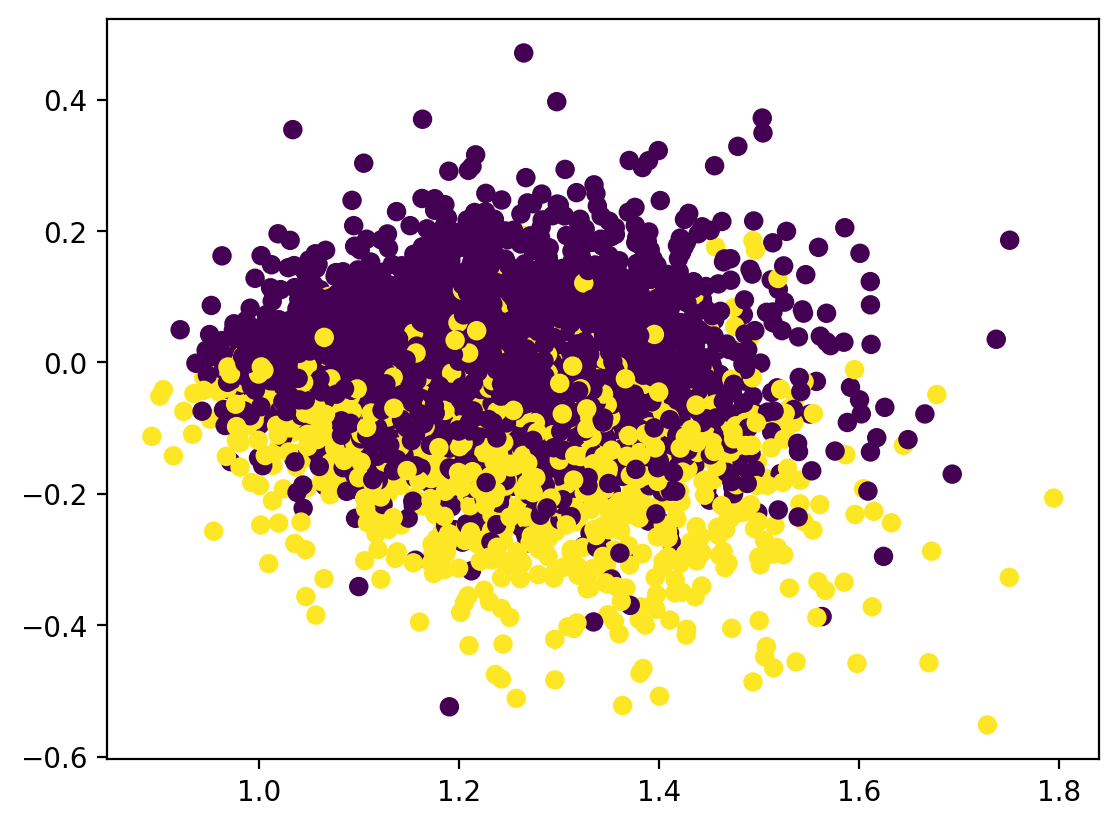

In [182]:
sml = train_wn_df.sample(5000)
plt.scatter( sml['std'], sml['mean'], c=sml['label'])

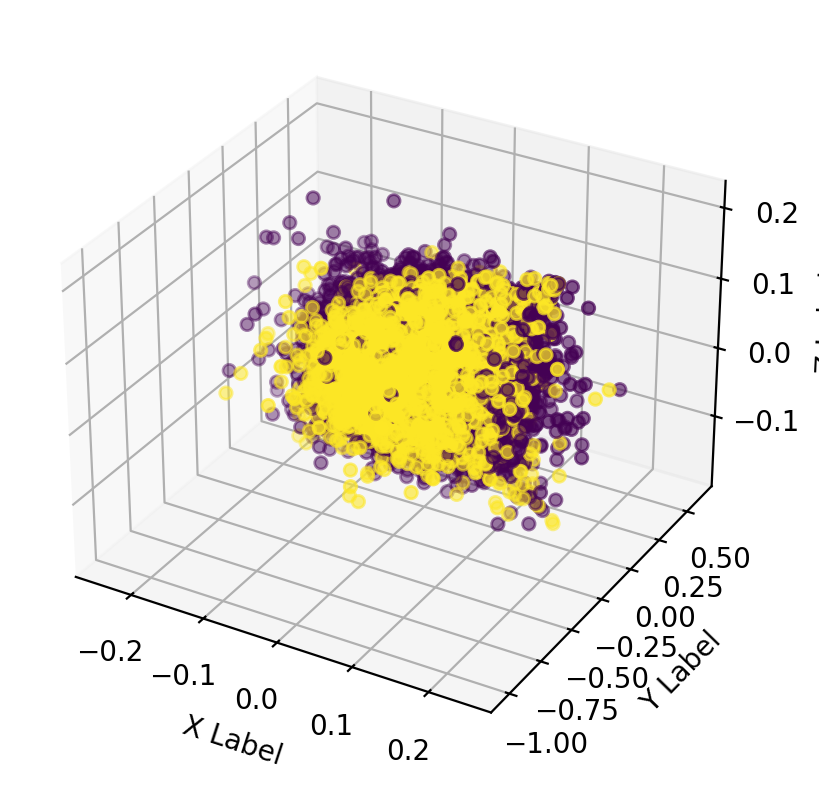

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train_wn_df['sec_dv_mean'], train_wn_df['mean'], train_wn_df['dv_mean'], c=train_wn_df['label'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()




In [197]:
train_wn_df['autocorr_lag1'] = train_wn_df['values'].apply(lambda x: pd.Series(x).autocorr(lag=1))

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [201]:
train_wn_df['autocorr_lag2'] = train_wn_df['values'].apply(lambda x: pd.Series(x).autocorr(lag=2))

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [204]:
train_wn_df['autocorr_lag3'] = train_wn_df['values'].apply(lambda x: pd.Series(x).autocorr(lag=3))

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


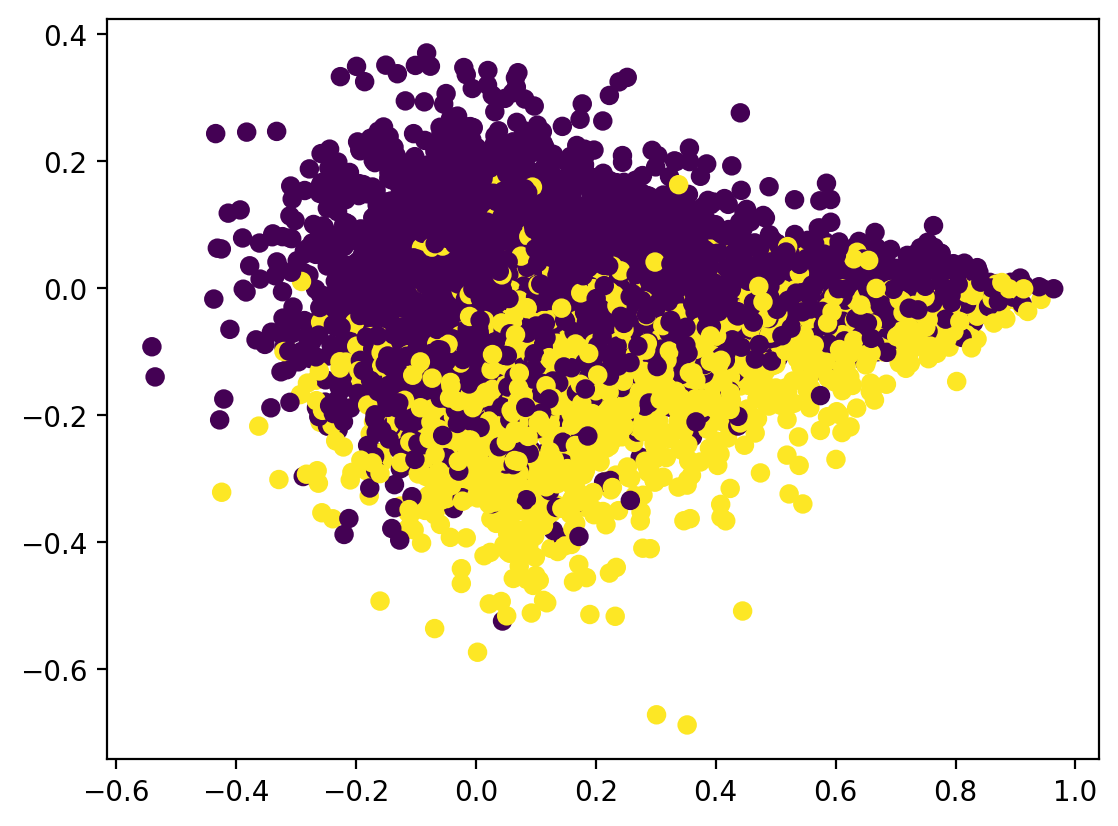

In [214]:
sml = train_wn_df.sample(10000)
plt.scatter(sml['autocorr_lag3'], sml['mean'], c=sml['label'])

In [194]:
pd.Series(train_wn_df['values'][0]).autocorr(lag=7)

0.15636715193998685

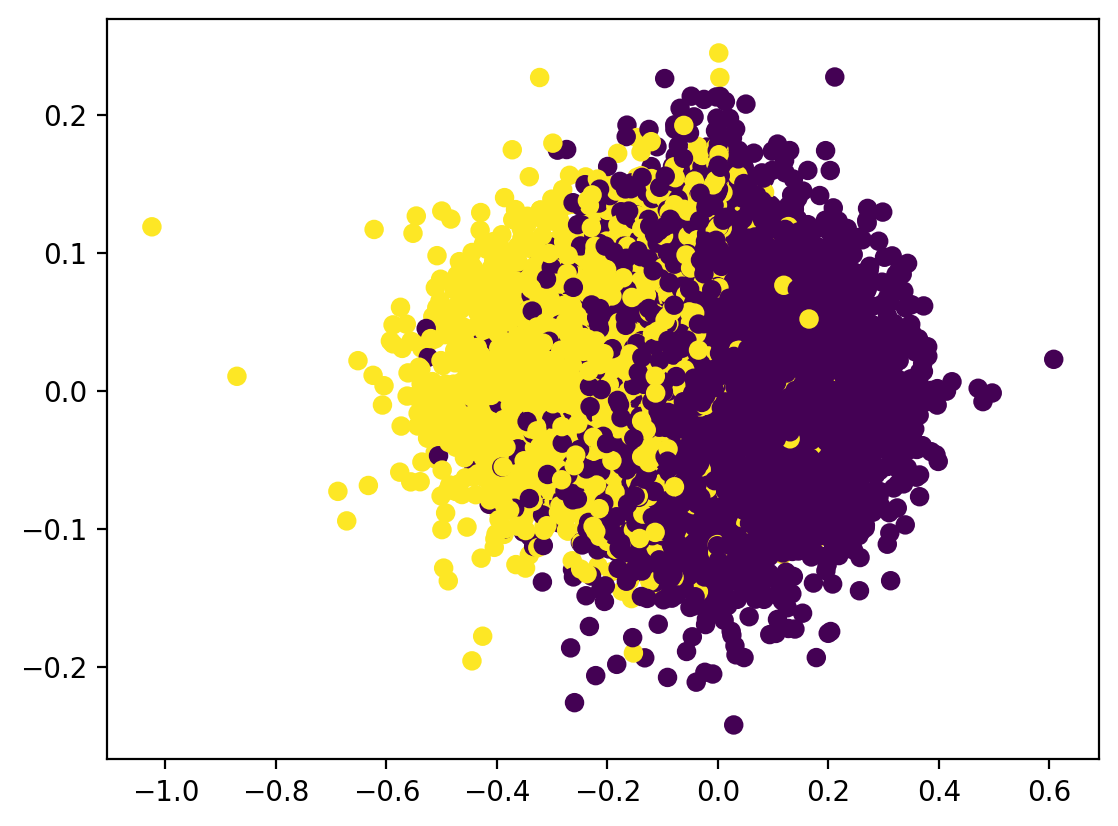

In [83]:
plt.scatter(train_wn_df['mean'], train_wn_df['sec_dv_mean'], c=train_wn_df['label'])

In [320]:
train_wn_df

,id,dates,values,label,dv_mean,mean,std,dv_std,mean_mul_dv_mean
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,-0.021148,0.023710,1.337272,1.993975,-0.000501
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,-0.022400,-0.310777,1.556337,2.000644,0.006961
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,0.014894,-0.046042,1.065023,1.073534,-0.000686
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,-0.040851,-0.130000,1.158201,0.888266,0.005311
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,0.037455,-0.270536,1.270529,1.717244,-0.010133
...,...,...,...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,-0.043148,0.163818,1.303965,1.691542,-0.007068
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,-0.003455,-0.112555,1.216413,1.313139,0.000389
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,0.042200,-0.201373,1.182551,1.372824,-0.008498
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,-0.047742,-0.075397,1.491254,1.605315,0.003600


In [322]:
train_df['ts_start_date'] = train_df['dates'].apply(lambda ts_dates: ts_dates[0])

In [323]:
test_df['ts_start_date'] = test_df['dates'].apply(lambda ts_dates: ts_dates[0])

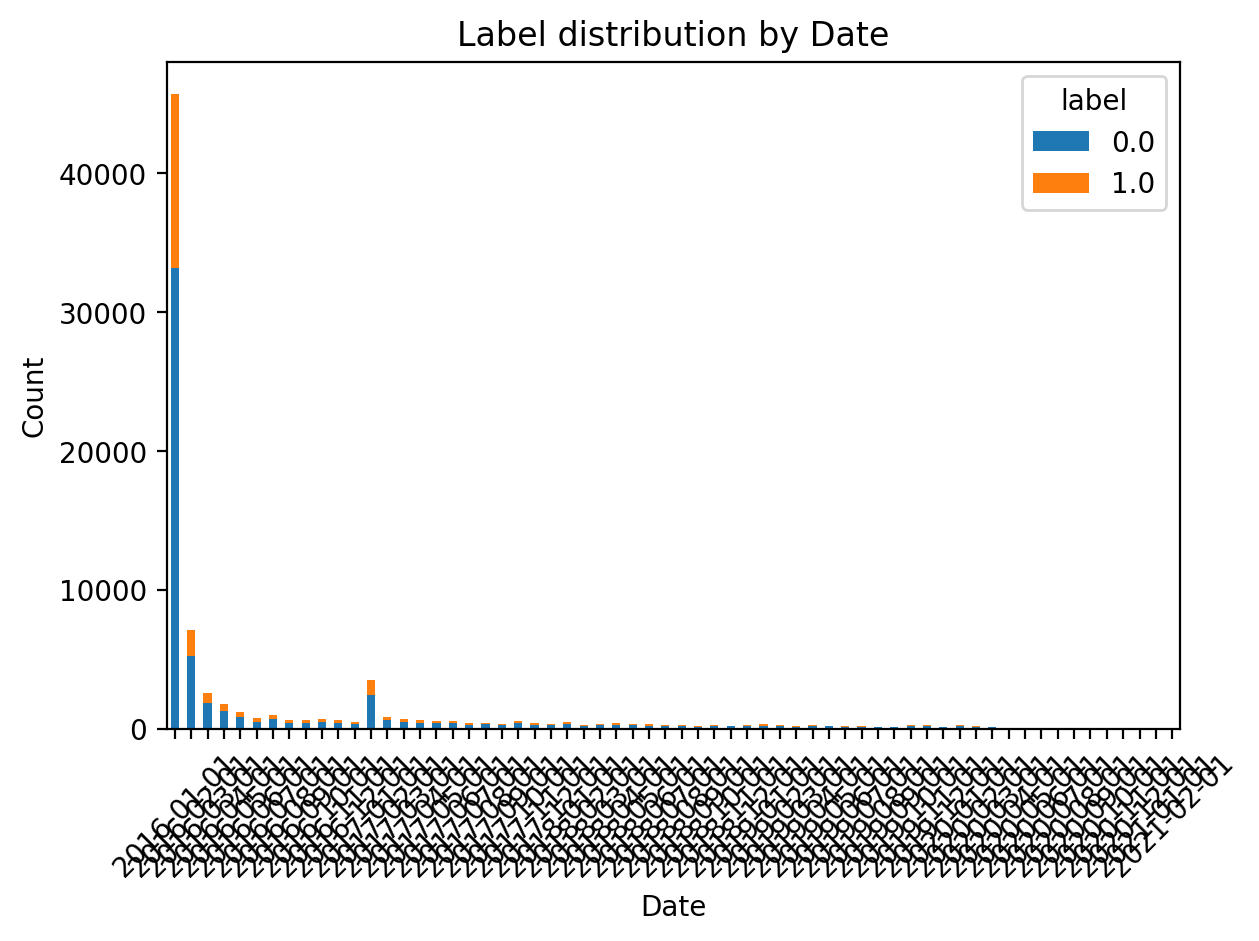

In [324]:
# Группируем данные по date и label, подсчитываем количество
grouped = train_df.groupby(['ts_start_date', 'label']).size().unstack(fill_value=0)

# Строим график
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Label distribution by Date')
plt.xticks(rotation=45)
plt.tight_layout()  # Чтобы подогнать разметку
plt.show()

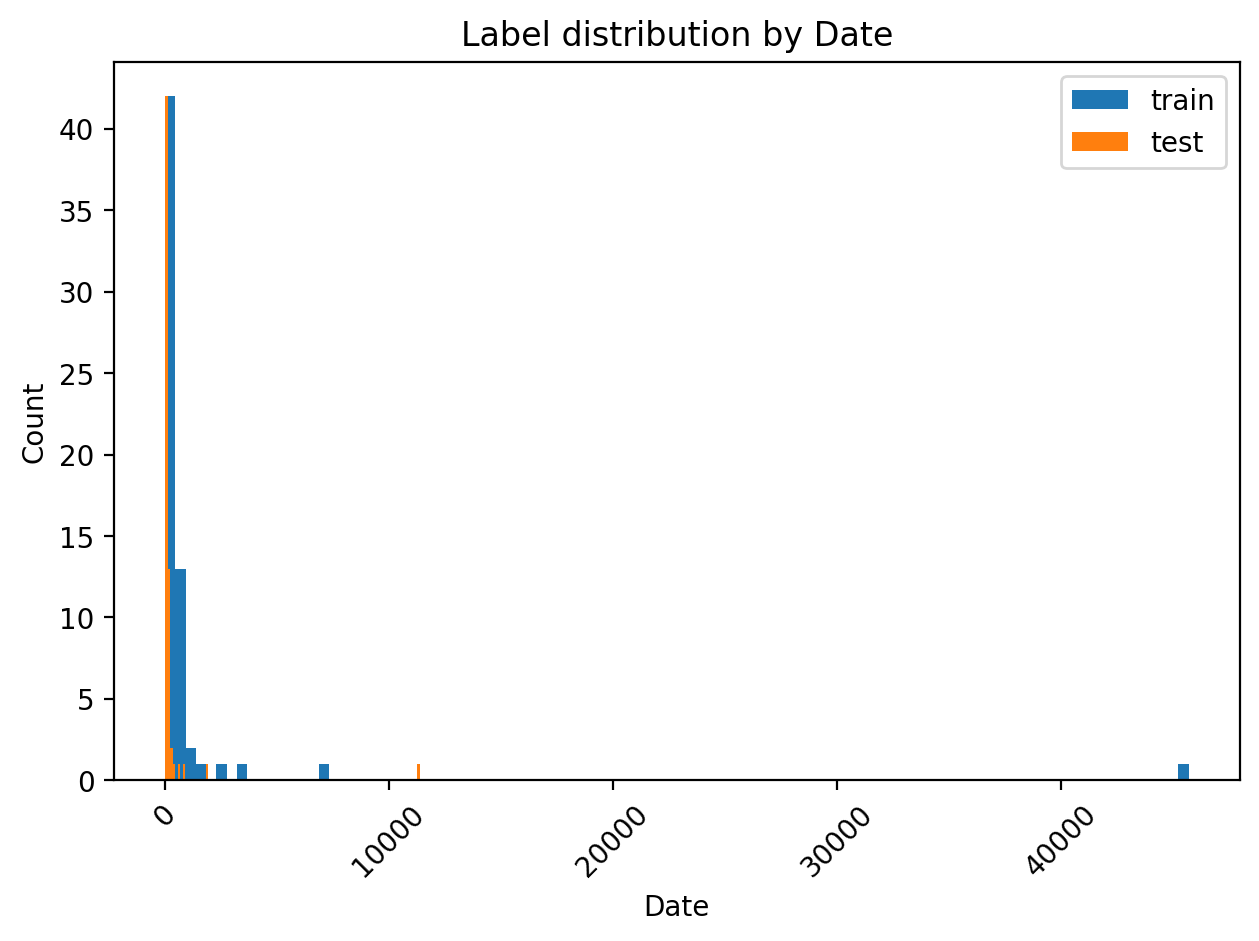

In [325]:
# Группируем данные по date и label, подсчитываем количество
grouped_train = train_df.groupby(['ts_start_date']).size()
grouped_test = test_df.groupby(['ts_start_date']).size()

# Строим график
grouped_train.plot(kind='hist', label="train", bins=100)
grouped_test.plot(kind='hist', label="test", bins=100)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Label distribution by Date')
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()  # Чтобы подогнать разметку
plt.show()

В тренировочном наборе данных есть дисбаланс классов, потребуется учесть это при обучении.

#### Подбор гиперпараметров модели

In [215]:
train_wn_df

,id,dates,values,label,razmax,dv_mean,dv_value,sec_dv_mean,mean,std,dv_std,mean_mul_dv_mean,autocorr_lag1,autocorr_lag2,autocorr_lag3
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,8.330000,-0.021148,"[-2.6500000000000004, -0.6099999999999999, 1.2...",-0.045167,0.023710,1.337272,1.993975,-0.000501,-0.113649,-0.098819,-0.058512
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,6.454409,-0.022400,"[2.44, -3.53, 0.18, -0.12000000000000001, -0.0...",0.065814,-0.310777,1.556337,2.000644,0.006961,0.189858,0.024816,0.018005
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,4.560000,0.014894,"[-0.35, 0.5700000000000001, -0.899999999999999...",-0.016304,-0.046042,1.065023,1.073534,-0.000686,0.501409,0.359250,0.210503
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,4.710000,-0.040851,"[-0.9099999999999999, -0.5200000000000001, 1.6...",-0.012174,-0.130000,1.158201,0.888266,0.005311,0.705215,0.523239,0.598640
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,5.370000,0.037455,"[0.81, 1.04, -1.49, 0.29999999999999993, -0.17...",0.047407,-0.270536,1.270529,1.717244,-0.010133,0.088913,-0.151230,-0.096043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,6.200000,-0.043148,"[0.9799999999999999, -0.2599999999999999, -1.3...",0.083396,0.163818,1.303965,1.691542,-0.007068,0.154770,0.011444,-0.160777
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,4.750000,-0.003455,"[0.9600000000000001, -1.4200000000000002, -1.3...",-0.001569,-0.112555,1.216413,1.313139,0.000389,0.428092,0.257381,0.015885
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,5.160000,0.042200,"[1.49, -0.41999999999999993, -1.18000000000000...",-0.038163,-0.201373,1.182551,1.372824,-0.008498,0.302005,0.428087,0.302201
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,5.960000,-0.047742,"[0.56, -3.77, 1.75, 0.92, 0.06000000000000005,...",0.010328,-0.075397,1.491254,1.605315,0.003600,0.418320,0.229390,0.015391


#### Catboost classifier и Optuna

In [216]:
X = train_wn_df.drop(['label'], axis=1)[['dv_mean', 'mean', 'std', 'dv_std', 'razmax', 'sec_dv_mean', 'mean_mul_dv_mean', 'autocorr_lag1',	'autocorr_lag2', 'autocorr_lag3']]
y = train_wn_df['label']

In [219]:

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 7),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    roc_aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X=X, y=y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = CatBoostClassifier(**param)
        clf.fit(X=X_train, 
                y=y_train, 
                eval_set=(X_test, y_test), 
                use_best_model=True,
                verbose=0)
        
        y_pred_prob = clf.predict_proba(X_test)
        roc_aucs.append(roc_auc_score(y_true=y_test, y_score=y_pred_prob[:, 1]))

    roc_aucs = np.array(roc_aucs)
    print(f"Mean {roc_aucs.mean()}, std {roc_aucs.std()}")
    return roc_aucs.mean() - roc_aucs.std()

In [220]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-10-21 20:35:18,290] A new study created in memory with name: no-name-672dc255-0248-4e8f-9dda-1a32d16519f2
[I 2024-10-21 20:35:35,720] Trial 0 finished with value: 0.8720051144692917 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09795900699056692, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8720051144692917, std 0.0022174506251397626


[I 2024-10-21 20:35:48,971] Trial 1 finished with value: 0.8316519122083594 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.010811214364044003, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4099970376366877}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8316519122083594, std 0.012215351798736921


[I 2024-10-21 20:36:38,178] Trial 2 finished with value: 0.8618890022630836 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06311361596737919, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8618890022630836, std 0.0017356512847153875


[I 2024-10-21 20:37:26,495] Trial 3 finished with value: 0.8634953870965237 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07475729402861273, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5691213407870387}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8634953870965237, std 0.00214271789368748


[I 2024-10-21 20:37:40,915] Trial 4 finished with value: 0.8603347755696646 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04812829959629073, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.882027808179651}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8603347755696646, std 0.0015177423855976398


[I 2024-10-21 20:38:25,986] Trial 5 finished with value: 0.8419717459603401 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012919425955010413, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8419717459603401, std 0.004105511936285597


[I 2024-10-21 20:38:42,637] Trial 6 finished with value: 0.8709699760636271 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08751541672262413, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4149500614088202}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8709699760636271, std 0.0019209016967088282


[I 2024-10-21 20:38:56,541] Trial 7 finished with value: 0.8373274111900655 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011468542689434116, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8373274111900655, std 0.002663576965583904


[I 2024-10-21 20:39:10,571] Trial 8 finished with value: 0.8542201587084521 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04018764936084493, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.17534534672745}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.8542201587084521, std 0.0022815400924800135


[I 2024-10-21 20:39:56,276] Trial 9 finished with value: 0.846746840330199 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04653352469839908, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.374383999180646}. Best is trial 0 with value: 0.8720051144692917.


Mean 0.846746840330199, std 0.0025596930171456135


[I 2024-10-21 20:40:14,028] Trial 10 finished with value: 0.8724775444052872 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09674988823331412, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8724775444052872, std 0.001973383183514204


[I 2024-10-21 20:40:31,656] Trial 11 finished with value: 0.8721019915521193 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.099089077087958, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8721019915521193, std 0.002121580715402831


[I 2024-10-21 20:40:49,510] Trial 12 finished with value: 0.8718426273713685 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09996945290535333, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8718426273713685, std 0.0019006987174531855


[I 2024-10-21 20:41:05,836] Trial 13 finished with value: 0.869994139925414 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07837367120575632, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.869994139925414, std 0.0018456608247820396


[I 2024-10-21 20:41:22,600] Trial 14 finished with value: 0.8712607044251719 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08290546760190298, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8712607044251719, std 0.0020422747949231995


[I 2024-10-21 20:41:38,531] Trial 15 finished with value: 0.8681382203802774 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06956100673648541, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8681382203802774, std 0.002462958581555696


[I 2024-10-21 20:41:55,415] Trial 16 finished with value: 0.8716865784166151 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09077644101873192, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.999729314570502}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8716865784166151, std 0.0021353267062600417


[I 2024-10-21 20:42:09,841] Trial 17 finished with value: 0.8539175710659663 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0270973657189301, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8539175710659663, std 0.0020415866762924515


[I 2024-10-21 20:42:59,096] Trial 18 finished with value: 0.8659667351649084 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.062317812359080384, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8659667351649084, std 0.0014869078350785775


[I 2024-10-21 20:43:14,761] Trial 19 finished with value: 0.8697715860631817 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09158785959588567, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12985186260148868}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8697715860631817, std 0.002351926908591324


[I 2024-10-21 20:43:31,268] Trial 20 finished with value: 0.8686541901414472 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06950933680071447, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8686541901414472, std 0.0021805829637155613


[I 2024-10-21 20:43:49,203] Trial 21 finished with value: 0.8719863811612356 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09942315913605, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8719863811612356, std 0.002140001847882668


[I 2024-10-21 20:44:06,065] Trial 22 finished with value: 0.8710221093092863 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09492599546207169, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8710221093092863, std 0.0021091558576887084


[I 2024-10-21 20:44:23,237] Trial 23 finished with value: 0.8710951714028503 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08505500675116383, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8710951714028503, std 0.0018772848522544195


[I 2024-10-21 20:44:40,923] Trial 24 finished with value: 0.8724548717883287 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09949532643409167, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8724548717883287, std 0.0020143781616061354


[I 2024-10-21 20:44:57,321] Trial 25 finished with value: 0.8702450270636302 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07895725191017093, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8702450270636302, std 0.0016879631148727738


[I 2024-10-21 20:45:51,083] Trial 26 finished with value: 0.8715535200119909 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09092848342889155, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.8724775444052872.


Mean 0.8715535200119909, std 0.002012773556269049


In [222]:
study.best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.09674988823331412,
 'depth': 6,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS'}

In [223]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [224]:
clf = CatBoostClassifier(**study.best_params)
clf.fit(X=X_train, 
                y=y_train, 
                eval_set=(X_test, y_test), 
                use_best_model=True,
                verbose=0)

Text(0.5, 1.0, 'Feature Importance')

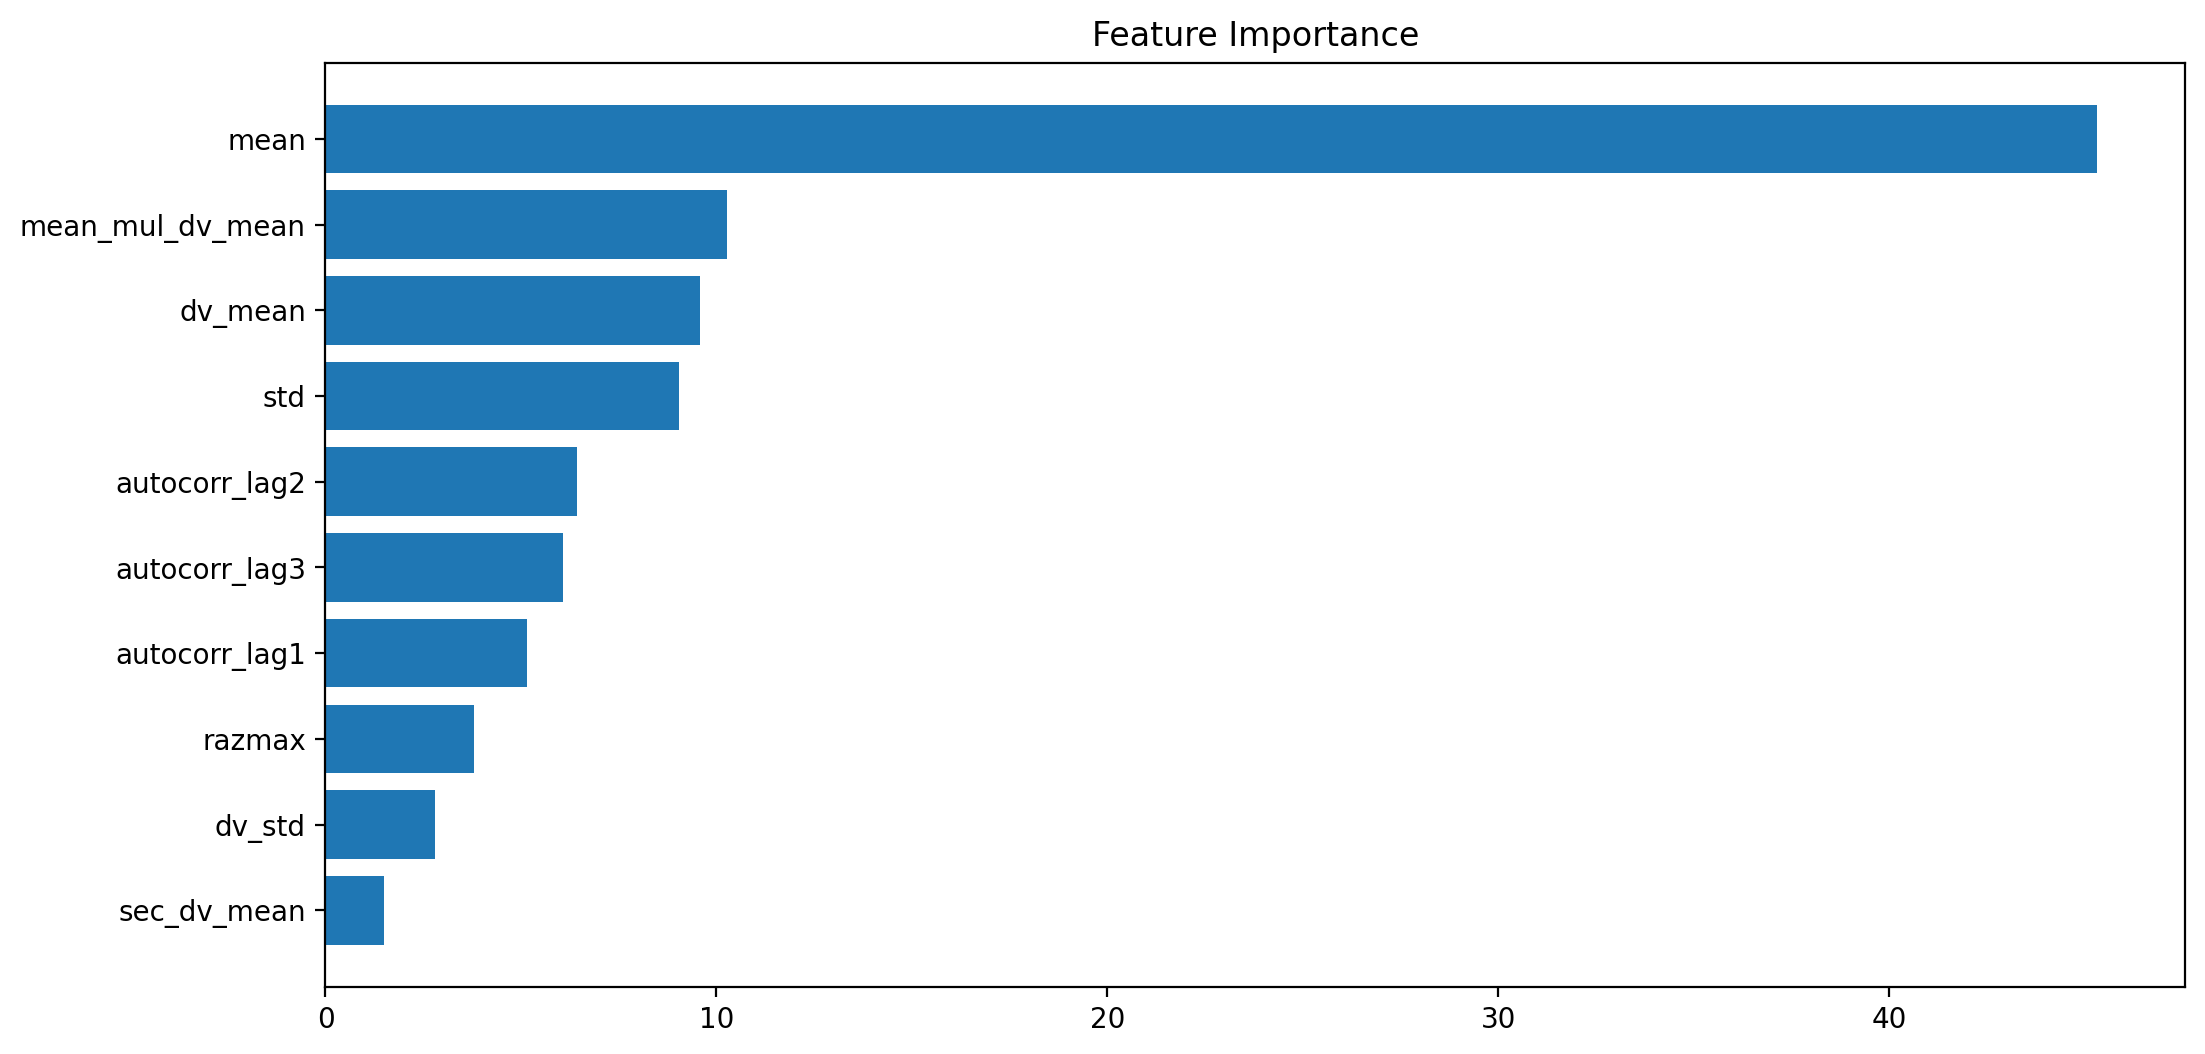

In [225]:

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


Построим `ROC` кривую и посчитаем `AUC`

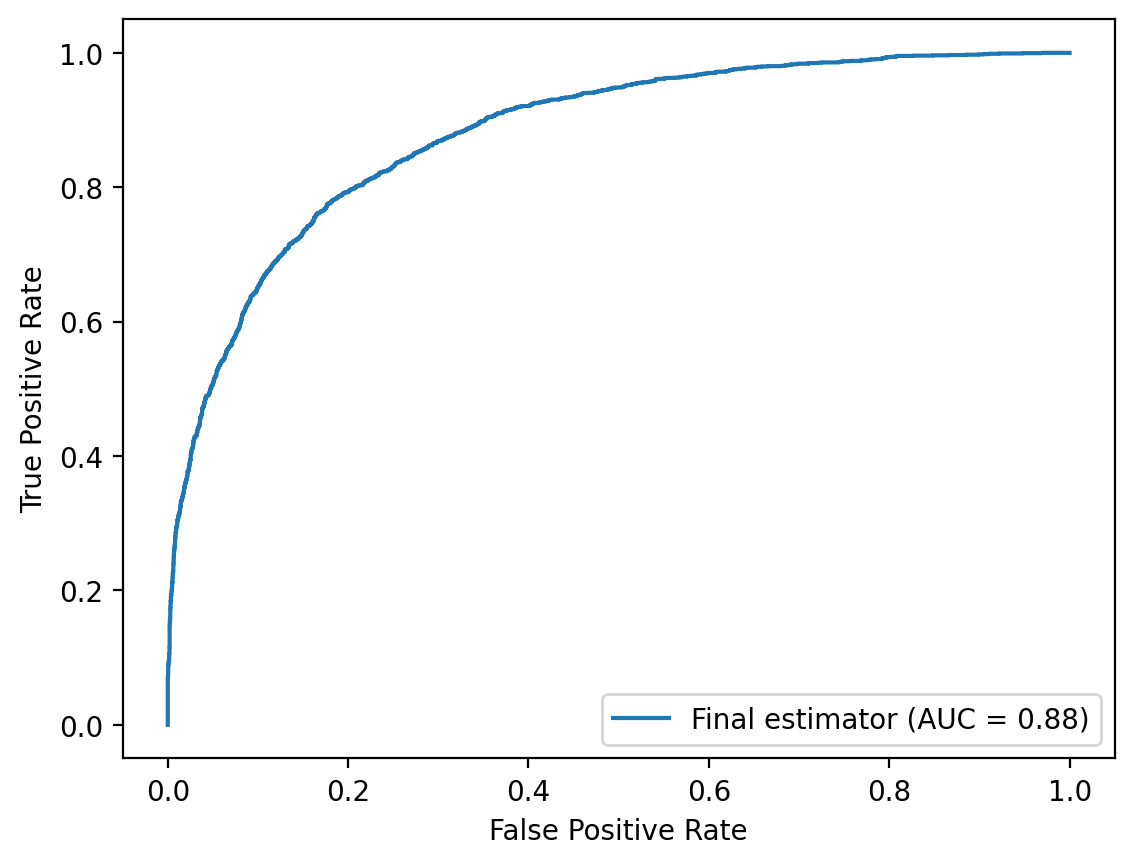

In [230]:
y = y_test
pred = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Final estimator')

display.plot()
plt.show()

#### Формируем посылку

In [161]:
test_df['ts_start_date'] = test_df['ts_start_date'].astype(str)
test_df['mean_ts_value'] = test_df['values'].apply(lambda x: np.array(x).mean())
test_df['std_ts_value'] = test_df['values'].apply(lambda x: np.array(x).std())
test_df['max_ts_value'] = test_df['values'].apply(lambda x: np.array(x).max())
test_df['min_ts_value'] = test_df['values'].apply(lambda x: np.array(x).min())
test_df['max_freq'] = test_df['frequencies'].apply(lambda x: np.array(x).max())
test_df['min_freq'] = test_df['frequencies'].apply(lambda x: np.array(x).min())

ids = test_df['id']
final_test_X = test_df[['mean_ts_value', 'std_ts_value','max_ts_value', 'min_ts_value', 'max_freq', 'min_freq', 'ts_start_date']]

In [63]:
submission = pd.read_csv('sample_submission.csv')
submission['id'] = ids
submission['score'] = clf.predict_proba(final_test_X)[:, 1]
submission.to_csv('submission.csv', index=False)

NameError: name 'ids' is not defined